## Comparison of ELMo and InferSent on Consumer Complaints Dataset

In [9]:
## Import Libraries

from sklearn.cluster import KMeans
from models import InferSent  ##models.py 
import tensorflow_hub as hub
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import torch
#import torch.six as six
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\u5ls7vs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\u5ls7vs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##### Descriptive Data Analysis and Data Preprocessing

In [135]:
#importing dataset

df= pd.read_csv(r"C:\Users\u5ls7vs\OneDrive - A1 Group\Desktop\complaints.csv", encoding= 'unicode_escape')
df.head()

C:\Users\u5ls7vs\Anaconda3\envs\elmo\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (9,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2022-10-27,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,"EQUIFAX, INC.",NY,10457,NaN,NaN,Web,2022-10-27,In progress,Yes,NaN,6133674
1,2022-10-21,Mortgage,VA mortgage,Applying for a mortgage or refinancing an exis...,NaN,NaN,Company has responded to the consumer and the ...,Freedom Mortgage Company,KY,40047,Servicemember,NaN,Web,2022-10-21,Closed with explanation,Yes,NaN,6112254
2,2022-10-19,Mortgage,VA mortgage,Struggling to pay mortgage,NaN,NaN,Company has responded to the consumer and the ...,Freedom Mortgage Company,TX,76502,Servicemember,NaN,Web,2022-10-19,Closed with explanation,Yes,NaN,6105001
3,2022-10-13,Mortgage,VA mortgage,Trouble during payment process,NaN,NaN,Company has responded to the consumer and the ...,Freedom Mortgage Company,VA,22308,Servicemember,Consent not provided,Web,2022-10-13,Closed with explanation,Yes,NaN,6084363
4,2022-10-28,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",CA,93560,NaN,NaN,Web,2022-10-28,In progress,Yes,NaN,6134907


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3033308 entries, 0 to 3033307
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 416.

In [137]:
# only select 'Consumer complaint narrative' column and drop missing values.

df2= pd.DataFrame(df['Consumer complaint narrative'])
df2.dropna(inplace= True)
df2.head()
len(df2)


1087560

In [138]:
# number of unique values in dataframe and drop duplicates

df2.drop_duplicates(inplace= True)
df2.nunique()
df2.head()

,Consumer complaint narrative
114,"On XX/XX/XXXX, I bought a car from XXXX XXXX. ..."
118,"On XX/XX/22, I submitted a dispute to my credi..."
158,IM A VICTIM OF IDENTITY THEFT I am writing in ...
163,I paid my individual portion prior to XXXX in ...
245,As the executor of my mother 's estate I sold ...


In [139]:
## reset index of dataframe

df2.reset_index(drop=True, inplace = True)
df2.head()

,Consumer complaint narrative
0,"On XX/XX/XXXX, I bought a car from XXXX XXXX. ..."
1,"On XX/XX/22, I submitted a dispute to my credi..."
2,IM A VICTIM OF IDENTITY THEFT I am writing in ...
3,I paid my individual portion prior to XXXX in ...
4,As the executor of my mother 's estate I sold ...


In [74]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 951793 entries, 114 to 3033305
Data columns (total 1 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Consumer complaint narrative  951793 non-null  object
dtypes: object(1)
memory usage: 14.5+ MB


In [ ]:
#Calculate the average length of paragraphs:

df2['length'] = df2['Consumer complaint narrative'].apply(len)
avg_length = df2['Consumer complaint narrative'].mean()

In [ ]:
#Calculate the distribution of paragraph lengths:

plt.figure(figsize=(10, 6))
sns.histplot(df2['length'], bins=30, kde=True)
plt.xlabel('Length of Paragraphs')
plt.ylabel('Frequency')
plt.title('Distribution of Paragraph Lengths')
plt.show()

###### Analyzing word frequency using bar chart and word colud

In [140]:
# Finding nouns from text

def extract_nouns(words):
    
    # Perform POS tagging
    pos_tags = nltk.pos_tag(words)
    
    # Extract only nouns
    nouns = [word for word, pos in pos_tags if pos in ('NN', 'NNS', 'NNP', 'NNPS')]
    
    return nouns




In [158]:
# Getting word frequencies

def get_word_freq(text_series):
    stop_words = set(stopwords.words('english'))
    words_list = []
    cleaned_text = clean_text(text_series)

    for text in cleaned_text:
        words = text.split()  # Split the text into words
        nouns = extract_nouns(words)
        for word in words:
            if word.lower() not in stop_words and word.lower() not in ('tI', 'ame', "''", 'would', 'also', 'usc', 'date', 'without') and word in nouns:  # Check if the word is not in stopwords
                words_list.append(word.lower())  # Append the word to the words_list

    word_counter = Counter(words_list)
    common_words = word_counter.most_common(20)

    return word_counter, common_words

# Calculate the frequency of each word:
word_freq_dict, common_words = get_word_freq(df2['Consumer complaint narrative'][0:560000])


###### Bar Chart

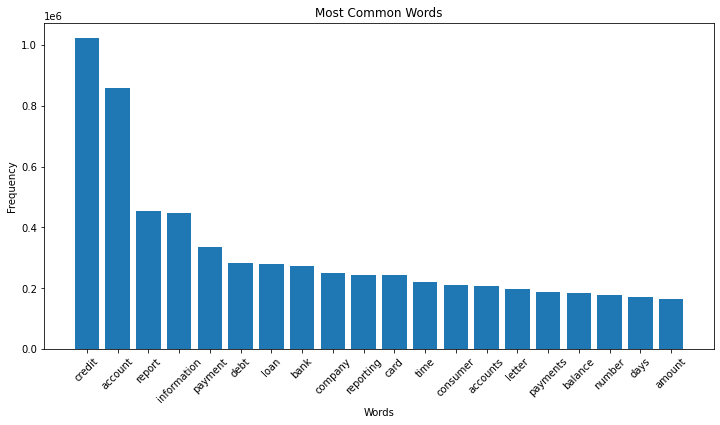

In [159]:

plt.figure(figsize=(12, 6))
words, frequencies = zip(*common_words)
plt.xticks(rotation=45)
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most Common Words')
plt.show()


###### Word Cloud

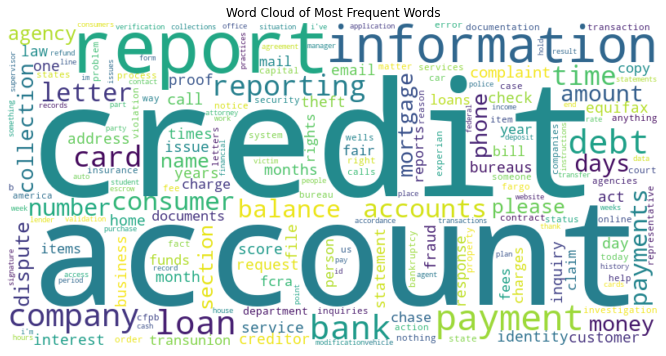

In [160]:

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()


#### Data Cleaning

In [96]:
punctuation = '!"#$%&()*+-/:;,<=>?@[\\]^_`{|}~"".'


def remove_punctuations(text):
    for p in punctuation:
        text= text.replace(p, "")
    return text
    
    
def clean_text(text):
    
    text= text.str.replace(r"\n","") #remove \n 
    
    text= text.str.replace(r"X{2,}","", regex= True) # remove XXX%
    
    text= text.str.replace(r'\d+','')  # remove numbers
    
    text= text.str.replace(r'\s+', ' ', regex= True) #remove whitespaces
      
    return [remove_punctuations(t) for t in text]

#### ELMo Word Embeddings

#### InferSent Sentence Embeddings

#### Kmeans with ELMo

#### Kmeans with InferSent

In [ ]:
k_clusters= 3
score = []
for i in range(1,k_clusters + 1):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=5,random_state=0)
    y_kmeans= kmeans.fit(text_embed)
    score.append(kmeans.inertia_)
plt.plot(range(1,k_clusters + 1 ),score)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.savefig('elbow.png')
plt.show()

In [ ]:
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(text_embed)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = text_embed.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),